# Deep Learning

## Part 2: Open Task - Part Of Speech Tagging (Custom Architecture)

---

> Kostis Konstantinos (p3352311) <br>
> Karousis Nikolaos (p3352321) <br>
> MSc Data Science (Part-Time) <br>
> Athens University Of Economics and Business

## Open Task

For the part 2 of the assignment the open task was selected, which is about part-of-speech tagging.

This notebook implements the custom architecture of the audio classification task.

## Dataset description
The dataset used, refers to the english language of the Universal Dependencies tree banks and more specifically GUM from Georgetown University. It contains 10761 sentences from different genres: academic, blog, fiction, government, news, nonfiction, social, spoken, web, wiki. The dataset is downloaded from Github and parsed using the conllu package, via a custom class named DatasetHandler.

- Treebank index page can be found here https://universaldependencies.org/treebanks/en_gum/index.html
- The actual data (train, dev, test) files can be found at https://github.com/UniversalDependencies/UD_English-GUM/tree/master

In [1]:
# Install needed libraries
!pip install -U conllu gensim requests tensorflow==2.12.0 keras-tuner==1.4.7 pandas==1.5.3 numpy==1.23.5 scikit-learn==1.3.0 matplotlib==3.8.4

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 77.7 MB/s eta 0:00:00
   ━━━━

In [2]:
## Allow access to the code directory
import sys
import os
from google.colab import drive

# Mount the drive
drive.mount('/content/drive', force_remount=True)

# Define the base path
base_path = '/content/drive/MyDrive/deep-learning-msc-data-science-2024-2025'

# Define the code path
code_folder = os.path.join(base_path, 'code')

# Add the 'code' folder to the sys.path
sys.path.append(code_folder)

Mounted at /content/drive


In [3]:
# Load libraries

import pandas as pd
from constants import *
from pos_utils import *
from pos_custom import *


## Fetch/Load the data

In [4]:
data_directory = os.path.join(base_path, 'data', 'pos_en_gmu')

train_ds_handler = DatasetHandler(data_directory, POS_TAG_TRAIN_URL, 'train')
train_ds_handler.fetch()

dev_ds_handler = DatasetHandler(data_directory, POS_TAG_DEV_URL, 'dev')
dev_ds_handler.fetch()

test_ds_handler = DatasetHandler(data_directory, POS_TAG_TEST_URL, 'test')
test_ds_handler.fetch()

## Basic statistics
Below you can find some basic statistics regarding the train, dev and test sets. Reported statistics are:

- Dataset split
- Number of sentences
- Average sentence length
- Number of words
- Number of unique words

In [5]:
train_stats = train_ds_handler.basic_stats()
dev_stats = dev_ds_handler.basic_stats()
test_stats = test_ds_handler.basic_stats()

stats = pd.concat([train_stats, dev_stats, test_stats], ignore_index=True)

stats

,Dataset,Sentences,Average Sentence Length,Words,Unique Words
0,train,9520,17.5,166918,15555
1,dev,1341,18.2,24375,4302
2,test,1285,18.9,24331,4820


## Initialize a DataProcessor and fit() on the train sentences

In [6]:
# Define the vocabulary size (taken from stats dataframe)
# +2 refers to the OOV (__UNK__) and PADDED words
VOCABULARY_SIZE = stats.iloc[0]['Unique Words'] + 2

In [7]:
MAX_SEQUENCE_LENGTH = 64

In [8]:
data_processor = DataProcessor(VOCABULARY_SIZE, MAX_SEQUENCE_LENGTH).fit(train_ds_handler.sentences)

## Construct the embeddings matrix

In [9]:
embeddings_wrapper = GensimEmbeddings(data_processor, VOCABULARY_SIZE, model_name='glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [10]:
embedding_matrix = embeddings_wrapper.embeddings_matrix()
embedding_matrix.shape

(15557, 100)

## Hyper-Parameter Tuning

In [11]:
tuner_directory = os.path.join(base_path, TUNERS_DIR)
pos_rnn_tuner = RNNPosTaggerTuner(tuner_directory, POS_TAG_CUSTOM_TUNER_PROJECT_NAME,
                                  train_ds_handler.sentences, dev_ds_handler.sentences,
                                  data_processor, embedding_matrix, n_stacked=3, train_size=0.4)

In [12]:
keras_pos_rnn_tuner = pos_rnn_tuner.tune(batch_size=64, epochs=15, max_trials=5, patience=2)

Trial 5 Complete [00h 06m 31s]
val_loss: 0.7703832983970642

Best val_loss So Far: 0.3050358295440674
Total elapsed time: 00h 38m 00s


In [13]:
best_hyperparams = keras_pos_rnn_tuner.get_best_hyperparameters()[0].values
best_hyperparams

{'dropout_layer_first': 0.2,
 'num_layers': 2,
 'gru_units_0': 192,
 'dropout_layer_0': 0.15000000000000002,
 'dense_units': 256,
 'dropout_layer_last': 0.2,
 'learning_rate': 0.01,
 'gru_units_1': 96,
 'dropout_layer_1': 0.5}

## Best Model Architecture


In [14]:
keras_pos_rnn_tuner.get_best_models()[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 64, 100)           1555700   
                                                                 
 dropout (Dropout)           (None, 64, 100)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 64, 384)          338688    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 64, 384)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64, 192)          277632    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 64, 192)           0

## Fit the RNN

In [15]:
models_directory = os.path.join(base_path, MODELS_DIR)
rnn_pos_tagger = RNNPosTagger(models_directory, POS_TAG_CUSTOM_WEIGHTS,
                              data_processor, embedding_matrix)

In [16]:
rnn_pos_tagger.fit(train_ds_handler.sentences, dev_ds_handler.sentences, best_hyperparams, batch_size=128, epochs=100)

Epoch 1/100
42/42 [==============================] - 14s 165ms/step
 — val_f1: 0.881243 — val_precision: 0.885152 — val_recall: 0.883277

Epoch 1: val_f1 improved from -inf to 0.88124, saving model to /content/drive/MyDrive/deep-learning-msc-data-science-2024-2025/models/pos_tag_custom.weights.h5
149/149 [==============================] - 195s 1s/step - loss: 0.8455 - sparse_categorical_accuracy: 0.7419 - val_loss: 0.3364 - val_sparse_categorical_accuracy: 0.8833 - val_f1: 0.8812 - val_recall: 0.8833 - val_precision: 0.8852
Epoch 2/100
42/42 [==============================] - 8s 187ms/step
 — val_f1: 0.905708 — val_precision: 0.912508 — val_recall: 0.903150

Epoch 2: val_f1 improved from 0.88124 to 0.90571, saving model to /content/drive/MyDrive/deep-learning-msc-data-science-2024-2025/models/pos_tag_custom.weights.h5
149/149 [==============================] - 156s 1s/step - loss: 0.3951 - sparse_categorical_accuracy: 0.8728 - val_loss: 0.2770 - val_sparse_categorical_accuracy: 0.9032 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 8s 191ms/step
 — val_f1: 0.907678 — val_precision: 0.911084 — val_recall: 0.907314

Epoch 8: val_f1 did not improve from 0.91482
149/149 [==============================] - 156s 1s/step - loss: 0.3556 - sparse_categorical_accuracy: 0.8877 - val_loss: 0.2669 - val_sparse_categorical_accuracy: 0.9073 - val_f1: 0.9077 - val_recall: 0.9073 - val_precision: 0.9111
Epoch 9/100


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 6s 143ms/step
 — val_f1: 0.903855 — val_precision: 0.905631 — val_recall: 0.904511

Epoch 9: val_f1 did not improve from 0.91482
149/149 [==============================] - 151s 1s/step - loss: 0.3793 - sparse_categorical_accuracy: 0.8810 - val_loss: 0.2883 - val_sparse_categorical_accuracy: 0.9045 - val_f1: 0.9039 - val_recall: 0.9045 - val_precision: 0.9056
Epoch 10/100
42/42 [==============================] - 8s 192ms/step
 — val_f1: 0.898203 — val_precision: 0.901524 — val_recall: 0.899604

Epoch 10: val_f1 did not improve from 0.91482
149/149 [==============================] - 151s 1s/step - loss: 0.4233 - sparse_categorical_accuracy: 0.8687 - val_loss: 0.3090 - val_sparse_categorical_accuracy: 0.8996 - val_f1: 0.8982 - val_recall: 0.8996 - val_precision: 0.9015
Epoch 11/100
42/42 [==============================] - 6s 141ms/step
 — val_f1: 0.884832 — val_precision: 0.887423 — val_recall: 0.886163

Epoch 11: val_f1 did not improve from 0.9148

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 8s 191ms/step
 — val_f1: 0.834127 — val_precision: 0.849227 — val_recall: 0.834873

Epoch 12: val_f1 did not improve from 0.91482
149/149 [==============================] - 150s 1s/step - loss: 0.6637 - sparse_categorical_accuracy: 0.7923 - val_loss: 0.5045 - val_sparse_categorical_accuracy: 0.8349 - val_f1: 0.8341 - val_recall: 0.8349 - val_precision: 0.8492
Epoch 13/100


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 6s 143ms/step
 — val_f1: 0.828749 — val_precision: 0.836801 — val_recall: 0.832069

Epoch 13: val_f1 did not improve from 0.91482
149/149 [==============================] - 150s 1s/step - loss: 0.7608 - sparse_categorical_accuracy: 0.7607 - val_loss: 0.5155 - val_sparse_categorical_accuracy: 0.8321 - val_f1: 0.8287 - val_recall: 0.8321 - val_precision: 0.8368
Epoch 14/100
42/42 [==============================] - 7s 173ms/step
 — val_f1: 0.828395 — val_precision: 0.840366 — val_recall: 0.835161

Epoch 14: val_f1 did not improve from 0.91482
Restoring model weights from the end of the best epoch: 4.
149/149 [==============================] - 150s 1s/step - loss: 0.7545 - sparse_categorical_accuracy: 0.7599 - val_loss: 0.5164 - val_sparse_categorical_accuracy: 0.8352 - val_f1: 0.8284 - val_recall: 0.8352 - val_precision: 0.8404
Epoch 14: early stopping


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
rnn_pos_tagger.model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 64, 100)           1555700   
                                                                 
 dropout_4 (Dropout)         (None, 64, 100)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 64, 384)          338688    
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 64, 384)           0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 64, 192)          277632    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 64, 192)          

## Plot training accuracy and loss curves

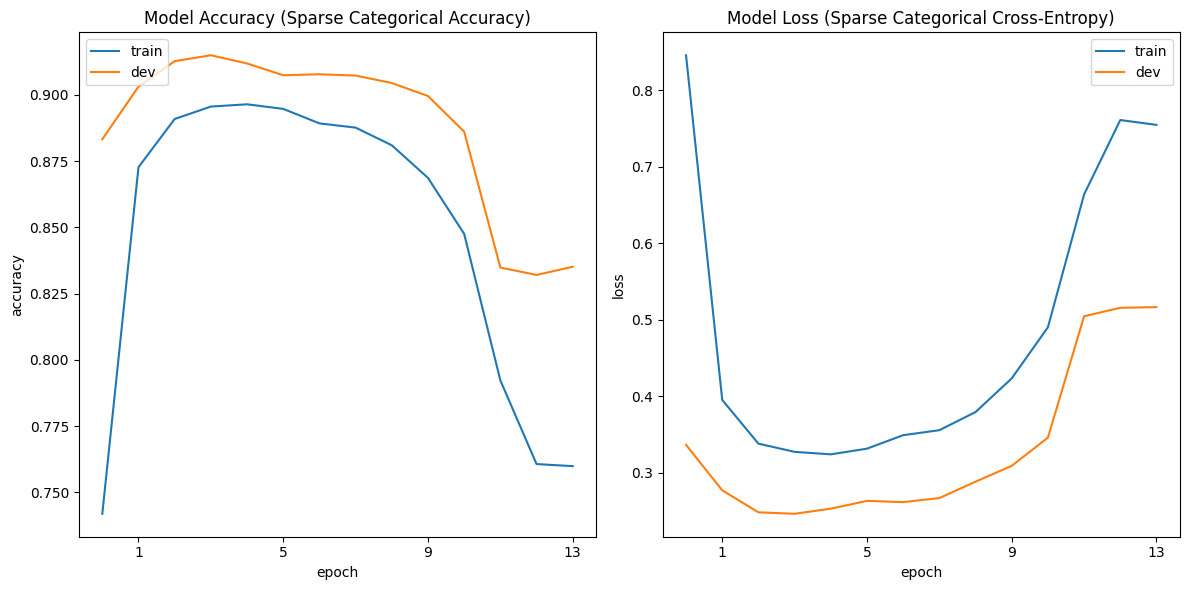

In [18]:
rnn_pos_tagger.plot_curves()

## Evaluate the RNN tagger on the training set (classification report)

In [19]:
train_set = train_ds_handler.sentences
train_classification_report_df, train_macro_average_df = rnn_pos_tagger.classification_report(train_set)

298/298 [==============================] - 48s 160ms/step


In [20]:
train_classification_report_df

,Class Id,Class Name,Precision,Recall,F1,Precision-Recall AUC
0,1,noun,0.884585,0.957273,0.919495,0.977465
1,2,punct,0.997968,0.998806,0.998387,0.999944
2,3,verb,0.939940,0.928120,0.933993,0.981130
3,4,adp,0.961192,0.963819,0.962503,0.993774
4,5,pron,0.983573,0.984933,0.984253,0.998596
5,6,det,0.984672,0.989878,0.987268,0.998756
6,7,adj,0.889742,0.889159,0.889450,0.951540
7,8,propn,0.917334,0.716877,0.804811,0.925908
8,9,aux,0.978254,0.987938,0.983072,0.997324
9,10,adv,0.909128,0.865769,0.886919,0.952274


In [25]:
train_macro_average_df

,Macro Average Precision,Macro Average Recall,Macro Average F1,Macro Average Precision Recall AUC
0,0.923516,0.891914,0.900054,0.942698


## Evaluate the RNN tagger on the validation set (classification report)

In [21]:
dev_set = dev_ds_handler.sentences
dev_classification_report_df, dev_macro_average_df = rnn_pos_tagger.classification_report(dev_set)

42/42 [==============================] - 8s 192ms/step


In [26]:
dev_classification_report_df

,Class Id,Class Name,Precision,Recall,F1,Precision-Recall AUC
0,1,noun,0.864787,0.905603,0.884724,0.954850
1,2,punct,0.997483,0.999055,0.998269,0.999851
2,3,verb,0.908842,0.871016,0.889527,0.955010
3,4,adp,0.942359,0.954731,0.948505,0.988154
4,5,pron,0.982720,0.977093,0.979898,0.997146
5,6,det,0.982484,0.985623,0.984051,0.999066
6,7,adj,0.864635,0.774603,0.817147,0.897866
7,8,propn,0.643536,0.659844,0.651588,0.769676
8,9,aux,0.964467,0.988848,0.976505,0.995372
9,10,adv,0.881308,0.823581,0.851467,0.920557


In [22]:
dev_macro_average_df

,Macro Average Precision,Macro Average Recall,Macro Average F1,Macro Average Precision Recall AUC
0,0.877003,0.832743,0.84116,0.891604


## Evaluate the RNN tagger on the test set (classification report)

In [23]:
test_set = test_ds_handler.sentences
test_classification_report_df, test_macro_average_df = rnn_pos_tagger.classification_report(test_set)

41/41 [==============================] - 6s 139ms/step


In [24]:
test_classification_report_df

,Class Id,Class Name,Precision,Recall,F1,Precision-Recall AUC
0,1,noun,0.828571,0.893577,0.859847,0.938891
1,2,punct,0.995708,0.998345,0.997025,0.999971
2,3,verb,0.915107,0.851702,0.882267,0.950880
3,4,adp,0.943785,0.965573,0.954555,0.987990
4,5,pron,0.976096,0.983936,0.980000,0.997756
5,6,det,0.982898,0.987589,0.985238,0.998281
6,7,adj,0.829006,0.812035,0.820432,0.891707
7,8,propn,0.667966,0.634960,0.651045,0.759302
8,9,aux,0.975692,0.983108,0.979386,0.996534
9,10,adv,0.891892,0.773670,0.828585,0.906766


In [27]:
test_macro_average_df

,Macro Average Precision,Macro Average Recall,Macro Average F1,Macro Average Precision Recall AUC
0,0.860463,0.823795,0.828701,0.885361


## Remarks

- The model performs terribly with respect to class `X` (more info [here](https://universaldependencies.org/treebanks/en_gum/en_gum-pos-X.html)) as PR-AUC reports ~ 24%

- The model overfits, as it can be seen from the training curves. Loss is decreasing at first, and gradually increases.